# General Inputs + Imports

In [1]:
brain = "8649" #brain ID
axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/" #path to directory where training/validation data should be stored

## Input Checks and Imports

In [2]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
from skimage import io, measure
import napari
import random
import h5py
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
from skimage.morphology import skeletonize
from axon_data import brain2paths, brain2centers
import os
from util import json_to_points
import scipy.ndimage as ndi
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

%gui qt5

# Useful variables
base_dir = (
    axon_data_dir + 
    "brain"
    + brain
    + "/"
)

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

layers = brain2paths[brain].keys()
for layer in ["ab", "bg", "endo", "mask"]:
    if layer not in layers and "base" not in layers:
        raise ValueError(f"{layer} not in brain2paths[{brain}].keys()")

if "base" in brain2paths[brain].keys():
    if "http" in brain2paths[brain]["base"]:
        raise ValueError(f"Cannot write to http link, only can write to precomputed://s3 link")
else:
    if "http" in brain2paths[brain]["mask"]:
        raise ValueError(f"Cannot write to http link, only can write to precomputed://s3 link")

# Download benchmark data

## Inputs

In [4]:
dataset_to_save = "val" #train or val

## Input checks

In [5]:
if f"{dataset_to_save}_info" not in layers:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")

## Setup paths

In [6]:
if brain in brain2centers.keys():
    centers_train = brain2centers[brain][0]
    centers_val = brain2centers[brain][1]  # annotate z slice 25, 50 and 75
    print(f"{len(centers_train)} training samples, {len(centers_val)} val samples")
elif "val_info" in brain2paths[brain].keys():
    centers_val = json_to_points(brain2paths[brain]["val_info"]["url"])[
        brain2paths[brain]["val_info"]["layer"]
    ]
    print(f"{len(centers_val)} val samples")


if "train_info" in brain2paths[brain].keys():
    centers_train = json_to_points(brain2paths[brain]["train_info"]["url"])[
        brain2paths[brain]["train_info"]["layer"]
    ]
    print(f"{len(centers_train)} train samples")

if dataset_to_save == "train":
    centers = centers_train
elif dataset_to_save == "val":
    centers = centers_val
else:
    raise ValueError(f"dataset_to_save must be train or val not {dataset_to_save}")


mip = 0

if "base" in brain2paths[brain].keys():
    base_dir_s3 = brain2paths[brain]["base"]
    dir = base_dir_s3 + "Ch_647"
    vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
    dir = base_dir_s3 + "Ch_561"
    vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
    dir = base_dir_s3 + "Ch_488"
    vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")

    dir = base_dir_s3 + "axon_mask"
    try:
        vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
    except:
        print("vol_mask not found")
else:
    dir = brain2paths[brain]["ab"]
    vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
    dir = brain2paths[brain]["bg"]
    vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
    dir = brain2paths[brain]["endo"]
    vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")

    if "mask" in brain2paths[brain].keys():
        dir = brain2paths[brain]["mask"]
        try:
            vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
        except:
            print("vol_mask not found")

30 points in val layer
5 points in train layer
30 val samples
30 points in val layer
5 points in train layer
5 train samples
fg shape: (5606, 5929, 3900, 1) at [1830. 1830. 2000.]
bg shape: (5606, 5929, 3900, 1) at [1830. 1830. 2000.]
endo shape: (5606, 5929, 3900, 1) at [1830. 1830. 2000.]


## Download data

In [8]:
# for ilastik - blue/1 is axon yellow/0 is bg
# prediction model is /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp


isExist = os.path.exists(base_dir)
if not isExist:
    print(f"creating directory: {base_dir}")
    os.makedirs(base_dir)

if dataset_to_save == "train":
    centers = centers_train
elif dataset_to_save == "val":
    centers = centers_val
else:
    raise ValueError("invalid dataset")

for i, center in enumerate(centers):
    print(center)
    image_fg = vol_fg[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_fg = image_fg[:, :, :, 0]

    image_bg = vol_bg[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_bg = image_bg[:, :, :, 0]

    image_endo = vol_endo[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_endo = image_endo[:, :, :, 0]

    image_2channel = np.stack([image_bg, image_fg, image_endo], axis=0)

    fname = f"{base_dir}{dataset_to_save}_{int(center[0])}_{int(center[1])}_{int(center[2])}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

[3300.86474609375, 3732.05078125, 1284.5]


Downloading: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


[3381.758544921875, 2398.30078125, 1294.5]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


[888.3621215820312, 2259.841552734375, 1304.4998779296875]


Downloading: 100%|██████████| 8/8 [00:01<00:00,  6.61it/s]


[2358.12158203125, 4700.71923828125, 1276.4998779296875]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


[2919.6845703125, 529.3911743164062, 1277.4998779296875]


Downloading: 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]


[2968.0283203125, 2904.228759765625, 541.5]


Downloading: 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


[1896.228759765625, 1731.1473388671875, 541.5]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


[2029.02294921875, 2289.479736328125, 385.5]


Downloading: 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]


[2686.05029296875, 2838.939208984375, 386.5000305175781]


Downloading: 100%|██████████| 8/8 [00:00<00:00,  9.00it/s]


[775.7115478515625, 4829.8408203125, 2459.500244140625]


Downloading: 100%|██████████| 8/8 [00:00<00:00,  9.79it/s]


[2872.016845703125, 2728.28271484375, 1284.5]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


[2185.880126953125, 1315.826416015625, 1286.5]


Downloading: 100%|██████████| 8/8 [00:00<00:00, 10.39it/s]


[2353.219482421875, 4116.52685546875, 1291.5]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


[1349.5601806640625, 4348.26904296875, 2027.5]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


[1341.2037353515625, 1785.1141357421875, 2028.4998779296875]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


[3524.333251953125, 3585.627197265625, 955.5000610351562]


Downloading: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


[2363.180419921875, 3756.51416015625, 2118.5]


Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


[1769.4013671875, 4238.56591796875, 607.5000610351562]


Downloading: 100%|██████████| 8/8 [00:00<00:00, 10.09it/s]


[2437.473876953125, 1272.57666015625, 596.5]


Downloading: 100%|██████████| 8/8 [00:00<00:00, 10.89it/s]


[1555.7828369140625, 2142.477783203125, 596.4999389648438]


Downloading: 100%|██████████| 8/8 [00:00<00:00, 10.42it/s]


[906.6395263671875, 3850.671875, 2109.5]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


[610.686279296875, 2344.14013671875, 1170.5]


Downloading: 100%|██████████| 8/8 [00:00<00:00, 11.01it/s]


[496.1651611328125, 2843.26025390625, 1204.5001220703125]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


[964.952392578125, 2196.471435546875, 782.5000610351562]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


[2879.197998046875, 1610.3914794921875, 817.5001220703125]


Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


[1159.1865234375, 1432.600830078125, 858.5]


Downloading: 100%|██████████| 8/8 [00:00<00:00, 10.01it/s]


[2199.487060546875, 1316.16748046875, 873.4999389648438]


Downloading: 100%|██████████| 8/8 [00:00<00:00,  9.14it/s]


[3845.113525390625, 1957.6746826171875, 955.5000610351562]


Downloading: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


[3908.05224609375, 3033.82763671875, 957.5000610351562]


Downloading: 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


[1102.3961181640625, 1359.181884765625, 957.5]


Downloading: 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


# View downloaded data (optional)

## Inputs

In [ ]:
dset = "val"
num = "3"
scale = [1.8, 1.8, 2]

## View Image

In [ ]:
fname = base_dir + dset + "_" + num + ".h5"

with h5py.File(fname, "r") as f:
    pred = f.get("image_2channel")
    image_bg = pred[0, :, :, :]
    image_fg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

# Execute Ilastik Training

for ilastik - blue/1 is axon yellow/0 is bg

Apply the ilastik pixel classification model to the downloaded data, results should be located in the same directory at the subvolumes, with the addition of "_Probabilities" appended to the file names

# Check results

## Validation

32 total validation subvolumes
Thresh: 0.02 --- Total prec.: 0.172 total rec.: 0.997 w/1226/33888 total pos/neg voxels. F-score: 0.2927
Thresh: 0.04 --- Total prec.: 0.236 total rec.: 0.990 w/1226/33888 total pos/neg voxels. F-score: 0.3807
Thresh: 0.06 --- Total prec.: 0.298 total rec.: 0.986 w/1226/33888 total pos/neg voxels. F-score: 0.4578
Thresh: 0.08 --- Total prec.: 0.353 total rec.: 0.982 w/1226/33888 total pos/neg voxels. F-score: 0.5199
Thresh: 0.10 --- Total prec.: 0.405 total rec.: 0.970 w/1226/33888 total pos/neg voxels. F-score: 0.5712
Thresh: 0.12 --- Total prec.: 0.453 total rec.: 0.956 w/1226/33888 total pos/neg voxels. F-score: 0.6149
Thresh: 0.14 --- Total prec.: 0.496 total rec.: 0.942 w/1226/33888 total pos/neg voxels. F-score: 0.6496
Thresh: 0.16 --- Total prec.: 0.530 total rec.: 0.928 w/1226/33888 total pos/neg voxels. F-score: 0.6748
Thresh: 0.18 --- Total prec.: 0.571 total rec.: 0.918 w/1226/33888 total pos/neg voxels. F-score: 0.7040
Thresh: 0.20 --- Total p

<matplotlib.legend.Legend object at 0x160eddfa0>

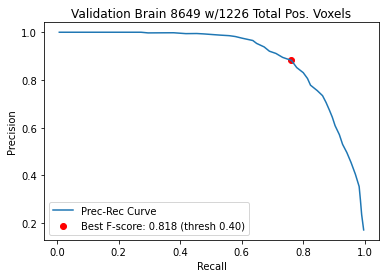

In [9]:
spacing = 0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")

for threshold in thresholds:
    true_pos_total = 0
    false_pos_total = 0
    true_labels_total = 0
    true_labels_total_neg = 0
    for fname_prob in files:

        fname_im = fname_prob[:-17] + ".h5"
        f = h5py.File(fname_im, "r")
        im = f.get("image_2channel")
        im_bg = im[0, :, :, :]
        im_fg = im[1, :, :, :]

        fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
        f = h5py.File(fname_lab, "r")
        gt = f.get("exported_data")
        gt = gt[0, :, :, :]
        pos_labels = gt == 2
        neg_labels = gt == 1

        f = h5py.File(fname_prob, "r")
        seg = f.get("exported_data")
        seg = seg[1, :, :, :]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        true_labels_neg = np.sum(neg_labels)
        true_labels_total_neg += true_labels_neg

    precision_total = true_pos_total / (true_pos_total + false_pos_total)
    recall_total = true_pos_total / true_labels_total
    fscore = 2 / (1 / precision_total + 1 / recall_total)
    print(
        f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total}/{true_labels_total_neg} total pos/neg voxels. F-score: {fscore:.4f}"
    )
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
        best_threshold = threshold
    precisions.append(precision_total)
    recalls.append(recall_total)
plt.plot(recalls, precisions, label="Prec-Rec Curve")
plt.scatter(
    [best_recall],
    [best_prec],
    c="red",
    label=f"Best F-score: {best_fscore:.3f} (thresh {best_threshold:.2f})",
)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title(f"Validation Brain {brain} w/{true_labels_total} Total Pos. Voxels")
plt.legend()

## Examine best threshold

In [ ]:
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")


for i, fname_prob in enumerate(files):
    fname_im = fname_prob[:-17] + ".h5"
    f = h5py.File(fname_im, "r")
    im = f.get("image_2channel")
    im_bg = im[0, :, :, :]
    im_fg = im[1, :, :, :]
    im_endo = im[2, :, :, :]

    fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
    f = h5py.File(fname_lab, "r")
    gt = f.get("exported_data")
    gt = gt[0, :, :, :]
    pos_labels = gt == 2
    neg_labels = gt == 1

    f = h5py.File(fname_prob, "r")
    seg = f.get("exported_data")
    seg = seg[1, :, :, :]
    mask = seg > best_threshold

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    true_labels = np.sum(pos_labels)
    true_labels_neg = np.sum(neg_labels)

    if true_labels == 0:
        recall = 1
    else:
        recall = true_pos/true_labels

    if true_pos + false_pos == 0:
        precision = 1
    else:
        precision = true_pos/(true_pos + false_pos)

    if precision < 0.8 or recall < 0.8:
        print(f"{i}) {fname_prob}: prec{precision} recall: {recall}")
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_fg, name=f"fg {i}")
        viewer.add_image(im_bg, name="bg")
        viewer.add_image(im_endo, name="endo")
        viewer.add_labels(mask, name="mask")
        viewer.add_labels(pos_labels+2*neg_labels, name="pos labels")



## Paper figure for all validation

10 total validation subvolumes for brain 8650
29 total validation subvolumes for brain 8649
10 total validation subvolumes for brain 8613
10 total validation subvolumes for brain 8589
14 total validation subvolumes for brain 8590
15 total validation subvolumes for brain 8788


<AxesSubplot:xlabel='Recall', ylabel='Precision'>

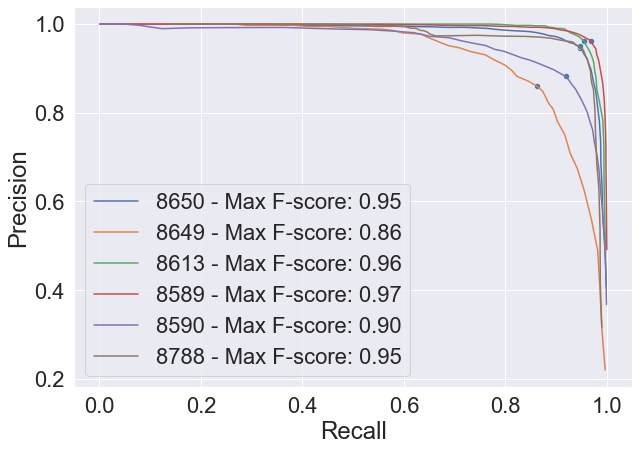

In [11]:
brains = ["8650", "8649", 
    "8613", "8589", "8590", "8788"]

brain_ids = []
precisions = []
recalls = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain in brains:

    base_dir = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain"
        + brain
        + "/"
    )

    spacing = 0.02
    thresholds = np.arange(spacing, 1.0, spacing)
    best_fscore = 0

    files = os.listdir(base_dir)
    files = [base_dir + f for f in files if "val" in f]
    files = [f for f in files if "_Probabilities.h5" in f]
    fiiles = [f for f in files if "val" in f]

    print(f"{len(files)} total validation subvolumes for brain {brain}")

    for threshold in thresholds:
        true_pos_total = 0
        false_pos_total = 0
        true_labels_total = 0
        true_labels_total_neg = 0
        for fname_prob in files:

            fname_im = fname_prob[:-17] + ".h5"
            f = h5py.File(fname_im, "r")
            im = f.get("image_2channel")
            im_bg = im[0, :, :, :]
            im_fg = im[1, :, :, :]

            fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
            f = h5py.File(fname_lab, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            f = h5py.File(fname_prob, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask = seg > threshold

            true_pos = np.sum(np.logical_and(mask, pos_labels))
            true_pos_total += true_pos
            false_pos = np.sum(np.logical_and(mask, gt == 1))
            false_pos_total += false_pos
            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels
            true_labels_neg = np.sum(neg_labels)
            true_labels_total_neg += true_labels_neg

        precision_total = true_pos_total / (true_pos_total + false_pos_total)
        recall_total = true_pos_total / true_labels_total

        precisions.append(precision_total)
        recalls.append(recall_total)
        brain_ids.append(brain)

        fscore = 2 / (1 / precision_total + 1 / recall_total)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision_total
            best_recall = recall_total
            best_threshold = threshold
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)
    best_fscores[brain] = best_fscore
for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample")
sns.scatterplot(x=best_recalls, y=best_precisions)

# Make annotation layer

In [13]:
if "base" in brain2paths[brain].keys():
    dir = brain2paths[brain]["base"] + "axon_mask"
else:
    dir = brain2paths[brain]["mask"]

info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint64",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol_bg.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol_bg.voxel_offset,  # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size=[128, 128, 2],  # units are voxels
    volume_size=vol_bg.volume_size,  # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

# Good samples:

brains = {
    "8613": "tph2 vglut3",
    "8650": "tph2 gad2",
    "8589": "tph2 vglut3",
    "8788": "tph2 vglut3",
}

# View coronal heat maps

## Inputs

In [28]:
type2id = {"tph2 gad2": ["8650", "8649"],
"tph2 vglut3": ["8589", "8590", "8613"]} #dictionary identifying subtype of brain
type2id_good = {"tph2 gad2": ["8650"],
"tph2 vglut3": ["8788", "8613", "8589", "8786"]}
type2id_select = {"tph2 gad2": ["8650"],
"tph2 vglut3": ["8788"]}

type2id = type2id_good

atlas_level = 5 #level of ARA to partition the figures

atlas_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif" # Path to 10um atlas parcellation
fold_on = True #Whether to fold results over midline

## Setup Atlas

In [29]:
import json
from parse_ara import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network

# create vikram object
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

# create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

In [30]:
atlas_level_nodes = []

print(f"Regions in selected atlas level ({atlas_level})")
for node in G.nodes:
    if G.nodes[node]["st_level"] == atlas_level:
        atlas_level_nodes.append(node)
        print(f"{node}: {G.nodes[node]['name']}")

Regions in selected atlas level (5)
313: Midbrain
528: Cerebellar cortex
519: Cerebellar nuclei
703: Cortical subplate
477: Striatum
803: Pallidum
549: Thalamus
1097: Hypothalamus
771: Pons
354: Medulla
315: Isocortex
698: Olfactory areas
1089: Hippocampal formation


In [31]:
vols_transformed_gad = [CloudVolume(brain2paths[id]["base"] + "axon_mask_transformed") if "base" in brain2paths[id].keys() else CloudVolume(brain2paths[id]["transformed_mask"]) for id in type2id["tph2 gad2"]]
vols_transformed_vglut = [CloudVolume(brain2paths[id]["base"] + "axon_mask_transformed")  if "base" in brain2paths[id].keys() else CloudVolume(brain2paths[id]["transformed_mask"]) for id in type2id["tph2 vglut3"]]

atlas = io.imread(atlas_path)
print(f"Shape of atlas image: {atlas.shape}")

Shape of atlas image: (1320, 800, 1140)


In [32]:
def find_atlas_level_label(label, atlas_level_nodes, atlas_level, G):
    if label == 0 or label not in G.nodes or G.nodes[label]["st_level"] <= atlas_level:
        return label
    else:
        counter = 0
        # find which region of atlas_level is parent
        for atlas_level_node in atlas_level_nodes:
            if label in nx.algorithms.dag.descendants(G, source=atlas_level_node):
                counter += 1
                atlas_level_label = atlas_level_node
        if counter == 0:
            preds = list(G.predecessors(label))
            if len(preds) != 1:
                raise ValueError(f"{len(preds)} predecessors of node {label}")
            atlas_level_label = find_atlas_level_label(preds[0], atlas_level_nodes, atlas_level, G)
            counter += 1
        if counter != 1:
            raise ValueError(f"{counter} atlas level predecessors of {label}")
        return atlas_level_label


def fold(image):
    half_width = np.round(image.shape[1]/2).astype(int)
    left = image[:,:half_width]
    right = image[:,half_width:]
    left = left + np.flip(right, axis=1)
    return left

## Display heatmaps

In [27]:
new_labels = {}
for z in np.arange(100, 1300, 200):
    slice = atlas[z, :, :]
    newslice = np.copy(slice)
    for label in tqdm(np.unique(slice), desc=f"Relabeling in z={z}"):
        atlas_level_label = find_atlas_level_label(label, atlas_level_nodes, atlas_level, G)
        newslice[slice == label] = atlas_level_label
        if atlas_level_label not in new_labels.keys():
            if atlas_level_label in G.nodes:
                name = G.nodes[atlas_level_label]["name"]
            else:
                name = "??"
            new_labels[atlas_level_label] = name

    print(new_labels)

    labels = measure.label(newslice)
    borders = 0 * labels
    for label in tqdm(np.unique(labels), desc=f"Processing labels in z={z}"):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    v = napari.Viewer()
    #v.add_labels(newslice, scale = [10,10])

    #get projection data
    for volnum, vol_transformed_gad in enumerate(vols_transformed_gad):
        slice_gad = np.squeeze(vol_transformed_gad[z-10:z+10,:,:])
        slice_gad = ndi.gaussian_filter(slice_gad.astype(float), sigma=(3,3,3))[10,:,:]
        slice_gad[newslice == 0] = 0
        if volnum == 0:
            slice_gad_total = slice_gad
        else:
            slice_gad_total += slice_gad

    for volnum, vol_transformed_vglut in enumerate(vols_transformed_vglut):
        slice_vglut = np.squeeze(vol_transformed_vglut[z-10:z+10,:,:])
        slice_vglut = ndi.gaussian_filter(slice_vglut.astype(float), sigma=(3,3,3))[10,:,:]
        slice_vglut[newslice == 0] = 0
        if volnum == 0:
            slice_vglut_total = slice_vglut
        else:
            slice_vglut_total += slice_vglut

    #only show hemisphere
    slice_vglut_total /= np.amax(slice_vglut_total)
    slice_gad_total /= np.amax(slice_gad_total)

    if fold_on:
        slice_gad_total = fold(slice_gad_total)
        slice_vglut_total = fold(slice_vglut_total)
        borders = borders[:,:int(borders.shape[1]/2)]

    projections= np.stack([slice_gad_total,slice_vglut_total,0*slice_vglut_total], axis = -1)
    v.add_image(projections, rgb=True, scale = [10,10], name=f"vglut=green,gad2=red")
    v.add_labels(borders*2, scale = [10,10], name=f"z={z}")
    v.scale_bar.unit = "um"
    v.scale_bar.visible = True


Relabeling in z=100: 100%|██████████| 4/4 [00:00<00:00, 160.35it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves'}


Relabeling in z=300: 100%|██████████| 46/46 [00:00<00:00, 236.47it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??'}


Relabeling in z=500: 100%|██████████| 104/104 [00:00<00:00, 242.28it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 1089: 'Hippocampal formation', 991: 'medial forebrain bundle system', 477: 'Striatum', 1097: 'Hypothalamus', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 997: 'root', 1009: 'fiber tracts', 182305696: '??', 182305712: '??'}


Relabeling in z=700: 100%|██████████| 159/159 [00:00<00:00, 231.06it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 1089: 'Hippocampal formation', 991: 'medial forebrain bundle system', 477: 'Striatum', 1097: 'Hypothalamus', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 997: 'root', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 312782560: '??', 560581568: '??'}


Relabeling in z=900: 100%|██████████| 124/124 [00:00<00:00, 237.97it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 1089: 'Hippocampal formation', 991: 'medial forebrain bundle system', 477: 'Striatum', 1097: 'Hypothalamus', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 997: 'root', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 312782560: '??', 560581568: '??', 313: 'Midbrain', 960: 'cerebellum related fiber tracts', 771: 'Pons', 512: 'Cerebellum', 312782592: '??', 312782656: '??', 484682464: '??', 589508416: '??', 607344832: '??'}


Relabeling in z=1100: 100%|██████████| 56/56 [00:00<00:00, 405.55it/s]


{0: '??', 698: 'Olfactory areas', 967: 'cranial nerves', 315: 'Isocortex', 526157184: '??', 1089: 'Hippocampal formation', 991: 'medial forebrain bundle system', 477: 'Striatum', 1097: 'Hypothalamus', 73: 'ventricular systems', 803: 'Pallidum', 983: 'lateral forebrain bundle system', 703: 'Cortical subplate', 997: 'root', 1009: 'fiber tracts', 182305696: '??', 182305712: '??', 549: 'Thalamus', 1000: 'extrapyramidal fiber systems', 312782560: '??', 560581568: '??', 313: 'Midbrain', 960: 'cerebellum related fiber tracts', 771: 'Pons', 512: 'Cerebellum', 312782592: '??', 312782656: '??', 484682464: '??', 589508416: '??', 607344832: '??', 519: 'Cerebellar nuclei', 354: 'Medulla', 528: 'Cerebellar cortex'}


Downloading: 100%|██████████| 900/900 [00:05<00:00, 153.22it/s]


# Display bar charts

## Inputs

In [19]:
brains = {
    # "3": "sert cre",
    # "4": "sert cre",
    "8613": "tph2 vglut3",
    "8604": "tbd",
    "8650": "tph2 gad2",
    "8589": "tph2 vglut3",
    #"8590": "tph2 vglut3",
    #"8649": "tph2 gad2",
    "8788": "tph2 vglut3",
    "8786": "tph2 vglut3",
    "11537": "tph2 gad2",
    "8790": "tph2 vglut3"
}

level = "coarse" #coarse or fine

regions = [688, 698, 1089, 583, 477, 803, 703, 1097, 549, 313, 1065]
allen_regions = [
    315,
    698,
    1089,
    703,
    477,
    803,
    549,
    1097,
    313,
    771,
    354,
    512,
]  # https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

## Setup data

In [13]:
counts = {}
for gene in set(brains.values()):
    count = 0
    for brain in brains.keys():
        if brains[brain] == gene:
            count += 1
    counts[gene] = count


quantification_dicts = {}

for brain in brains.keys():
    path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/wholebrain_"
        + brain
        + ".pkl"
    )
    with open(path, "rb") as f:
        quantification_dict = pickle.load(f)

    quantification_dicts[brain] = quantification_dict

In [14]:
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

In [15]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0

# Initialize nodes

while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain + " axon"] = 0
        G.nodes[node.id][brain + " total"] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

# add data
i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain + " axon"] = G.nodes[key][brain + " axon"] + float(
                quantification_dict[key][1]
            )
            G.nodes[key][brain + " total"] = G.nodes[key][brain + " total"] + float(
                quantification_dict[key][0]
            )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

# add child data to parent data
for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain + " axon"] = (
                    G.nodes[parent][brain + " axon"] + G.nodes[node][brain + " axon"]
                )
                G.nodes[parent][brain + " total"] = (
                    G.nodes[parent][brain + " total"] + G.nodes[node][brain + " total"]
                )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])


Max level: 10
0
0
2343053.0
196340416.0
493480545.0
27103979712.0


In [16]:
G.nodes[872]

{
    'level': 6,
    'st_level': 8,
    'name': 'Dorsal nucleus raphe',
    'acronym': 'DR',
    'label': '8) Dorsal nucleus raphe',
    '8613 axon': 678906.0,
    '8613 total': 8223808.0,
    '8604 axon': 8406.0,
    '8604 total': 6916288.0,
    '8650 axon': 736585.0,
    '8650 total': 9140032.0,
    '8589 axon': 801477.0,
    '8589 total': 11866176.0,
    '8788 axon': 935647.0,
    '8788 total': 25592960.0,
    '8786 axon': 78676.0,
    '8786 total': 38054016.0,
    '11537 axon': 0.0,
    '11537 total': 36904384.0,
    '8790 axon': 106404.0,
    '8790 total': 36235328.0
}

In [17]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain + " axon"]
    totals[brain] = total

axon_vols = []
axon_denss = []
axon_denss_norm = []
gene = []
subregion_name = []
region_name = []
brain_ids = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    #choose level here
    if level == "fine":
        children = list(G.successors(region))
    elif level == "coarse":
        children = [region]
    else:
        raise ValueError(f"level must be coarse or fine, not {level}")
        
    for child in children:
        for brain in quantification_dicts.keys():
            drn_norm_factor = G.nodes[872][brain + " axon"] / G.nodes[872][brain + " total"]

            if drn_norm_factor == 0:
                print(f"Warning: brain {brain} has no projection in DRN")
                drn_norm_factor = 1
                
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
                axon_denss_norm.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                dens = G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                axon_denss.append(
                    dens * 100
                )
                axon_denss_norm.append(dens / drn_norm_factor)

            axon_vols.append(G.nodes[child][brain + " axon"] / totals[brain] * 100)
            gene.append(brains[brain] + f" (n={counts[brains[brain]]})")
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])
            brain_ids.append(brain)

d = {
    "Percent Total Axon Volume (%)": axon_vols,
    "Axon Density (%)": axon_denss,
    "Normalized Axon Density": axon_denss_norm,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
    "Brain ID": brain_ids,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Claustrum
Populating: Striatum
Populating: Pallidum
Populating: Cortical subplate
Populating: Hypothalamus
Populating: Thalamus
Populating: Midbrain
Populating: Hindbrain


## Make bar chart

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Midbrain_tph2 vglut3 (n=6) vs. Midbrain_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:1.429e-01 U_stat=1.100e+01
Hindbrain_tph2 vglut3 (n=6) vs. Hindbrain_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:7.143e-02 U_stat=1.200e+01
Thalamus_tph2 vglut3 (n=6) vs. Thalamus_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:7.143e-02 U_stat=1.200e+01
Olfactory areas_tph2 vglut3 (n=6) vs. Olfactory areas_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:7.143e-02 U_stat=1.200e+01
Cerebral cortex_tph2 vglut3 (n=6) vs. Cerebral cortex_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_

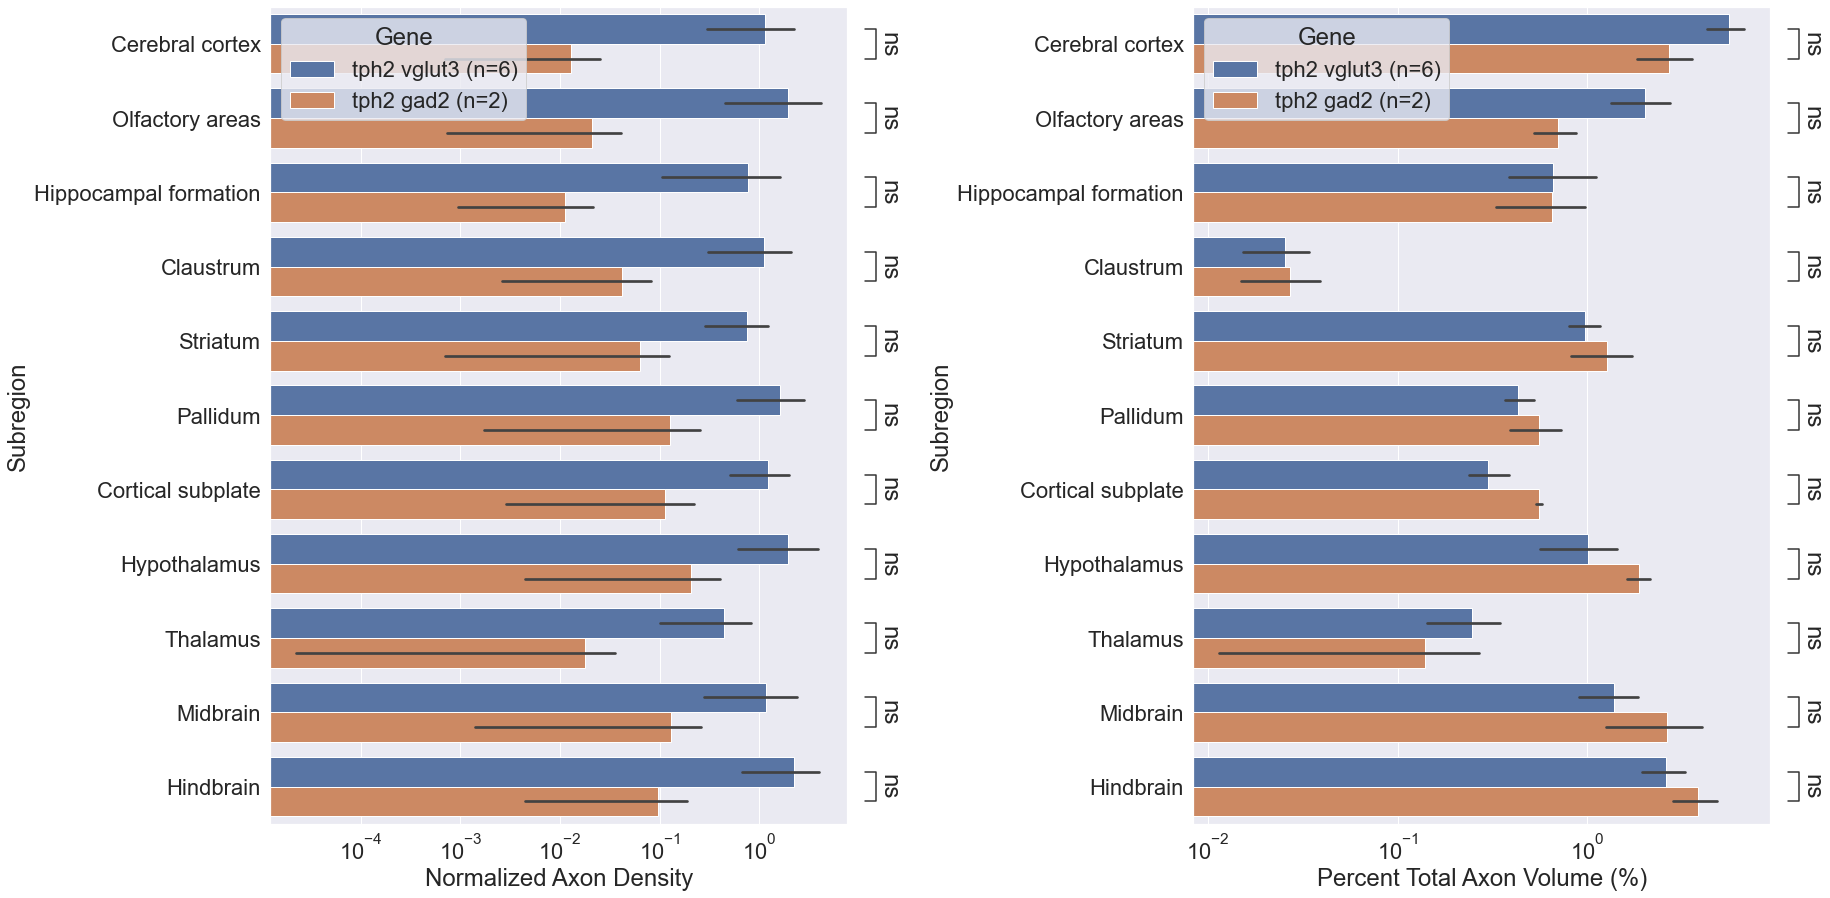

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(26, 13))
sns.set(font_scale=2)

test = "Mann-Whitney" 
#test = "t-test_ind"
correction = "fdr_by"

#density
fig_args = {
    "y": "Normalized Axon Density",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a,b) for idx, a in enumerate(genes) for b in genes[idx+1:]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Normalized Axon Density",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}


sns.set(font_scale = 2)
strpplot = sns.barplot(ax=axes[0], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(test=test, text_format="star", loc="outside", comparisons_correction=correction)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# percent total
fig_args = {
    "y": "Percent Total Axon Volume (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Percent Total Axon Volume (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

strpplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(test=test, text_format="star", loc="outside", comparisons_correction=correction)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

## Compare distributions with PCA

8613
8604
8650
8589
8788
8786
11537
8790


Text(0.5, 1.0, 'Projection Distribution PCA with Explained Variance: [0.74364157 0.20187101]')

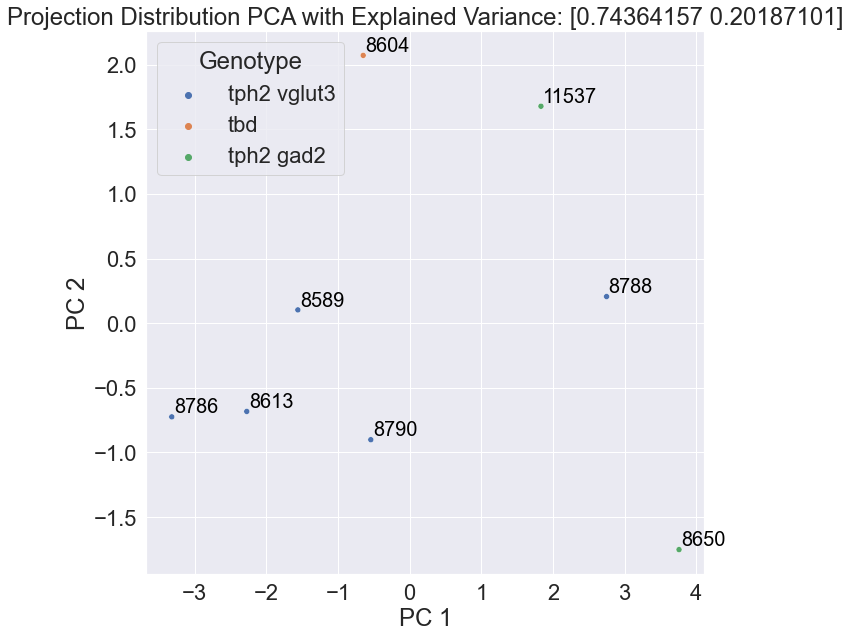

In [11]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")
    
    distrib = list(df.loc[df["Brain ID"] == brain]["Percent Total Axon Volume (%)"])
    X.append(distrib)
    
    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {"PC 1": X_2[:,0], "PC 2": X_2[:,1], "Genotype": genotypes, "Brain ID": brain_ids}
df_pca = pd.DataFrame(data = df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data = df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(x=df_pca["PC 1"][i]+0.03,y=df_pca["PC 2"][i]+0.03,s=df_pca['Brain ID'][i], 
        fontdict=dict(color='black',size=20))
          
plt.title(f"Projection Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}")

# Compare to Allen

### Subregion

In [ ]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)

        for brain in quantification_dicts.keys():
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                )

            if brain in ["B", "R"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

    region_name.append(G.nodes[region]["name"])

tree = ET.parse(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml"
)
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)


d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Detected Output Axons")

sns.barplot(x="Axon Density", y="Subregion", hue="Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

### Region

In [ ]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if (
            G.nodes[region][brain + " total"] == 0
            and G.nodes[region][brain + " axon"] == 0
        ):
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(
                G.nodes[region][brain + " axon"] / G.nodes[region][brain + " total"]
            )
            axon_vols.append(
                G.nodes[region][brain + " axon"]
                * np.product([1.82, 1.82, 2])
                * 10 ** (-9)
            )

        if brain in ["B", "R"]:
            gene.append("Sample " + brain)

        region_name.append(G.nodes[region]["name"])

tree = ET.parse(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml"
)
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(
                f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}"
            )
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)


d = {
    "Axon Density": axon_denss,
    "Axon Volume ($mm^3$)": axon_vols,
    "Gene": gene,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparing Axon Volumes to Allen Experiment")

sns.set(font_scale=2)

sns.barplot(
    ax=axes[0],
    x="Axon Density",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[0].set_title("Density")

sns.barplot(
    ax=axes[1],
    x="Axon Volume ($mm^3$)",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[1].set_title("Axon Volume")

fig.tight_layout()